In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd

import torch
from  torch import nn

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [6]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [7]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

In [8]:
# data.show_batch(3, figsize=(6,6))

In [13]:
learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=MSELossFlat()
).to_fp16()

In [14]:
learn.path = Path('..')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


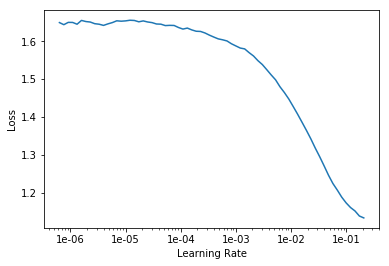

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.freeze_to(-1)
learn.fit_one_cycle(
    30, 
    slice(1e-2), 
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
        EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=3)
    ]
)

epoch,train_loss,valid_loss,time
0,1.042396,0.198158,01:11
1,0.604568,0.094170,01:10
2,0.315669,0.060653,01:11
3,0.202752,0.063023,01:11
4,0.169145,0.056395,01:11
5,0.142665,0.048790,01:11
6,0.105508,0.034817,01:11
7,0.084674,0.025406,01:11
8,0.064814,0.016685,01:11
9,0.073346,0.015950,01:11


Better model found at epoch 0 with valid_loss value: 0.19815798103809357.
Better model found at epoch 1 with valid_loss value: 0.09417025744915009.
Better model found at epoch 2 with valid_loss value: 0.060653455555438995.
Better model found at epoch 4 with valid_loss value: 0.05639549344778061.
Better model found at epoch 5 with valid_loss value: 0.048790331929922104.
Better model found at epoch 6 with valid_loss value: 0.03481731191277504.
Better model found at epoch 7 with valid_loss value: 0.025406161323189735.
Better model found at epoch 8 with valid_loss value: 0.016685357317328453.
Better model found at epoch 9 with valid_loss value: 0.015950292348861694.
Better model found at epoch 10 with valid_loss value: 0.012695029377937317.
Better model found at epoch 11 with valid_loss value: 0.012000830844044685.
Epoch 12: early stopping


In [21]:
learn = learn.load('resnet34_frozen_to_-1')
learn = learn.to_fp32()
learn.save('fastai_model')

In [22]:
# learn.show_results(rows=10)

In [23]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_regressor.predict(image)
        return str(result)

Overwriting pet_regression.py


In [24]:
# 1) import the custom BentoService defined above
from pet_regression import PetRegression

# 2) `pack` it with required artifacts
service = PetRegression.pack(pet_regressor=learn)

# 3) save your BentoSerivce
saved_path = service.save()

ModuleNotFoundError: No module named 'bentoml'

In [ ]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

In [ ]:
!pip install --upgrade {saved_path}

In [ ]:
!PetRegression predict --input=../data/resized_images/Abyssinian_1.jpg

In [ ]:
# !bentoml serve {saved_path}

In [ ]:
bento_tag = '{name}:{version}'.format(name=service.name, version=service.version)
print(bento_tag)

In [ ]:
!bentoml --verbose deployments delete facial-features-detector --force

In [ ]:
!bentoml --verbose deployment create facial-features-detector --bento {bento_tag} --platform aws-lambda --region us-east-1

In [ ]:
# !bentoml deployment list